In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/brain tumor detection.zip','r')
ref.extractall('/content/data')
ref.close()

In [ ]:
import os
tumor_dir=r'/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir=r'/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/data/Brain Tumor Data Set/Brain Tumor...  cancer
1  /content/data/Brain Tumor Data Set/Brain Tumor...  cancer
2  /content/data/Brain Tumor Data Set/Brain Tumor...  cancer
3  /content/data/Brain Tumor Data Set/Brain Tumor...  cancer
4  /content/data/Brain Tumor Data Set/Brain Tumor...  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


In [ ]:
tumor_df.shape

(4600, 2)

In [ ]:
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [ ]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

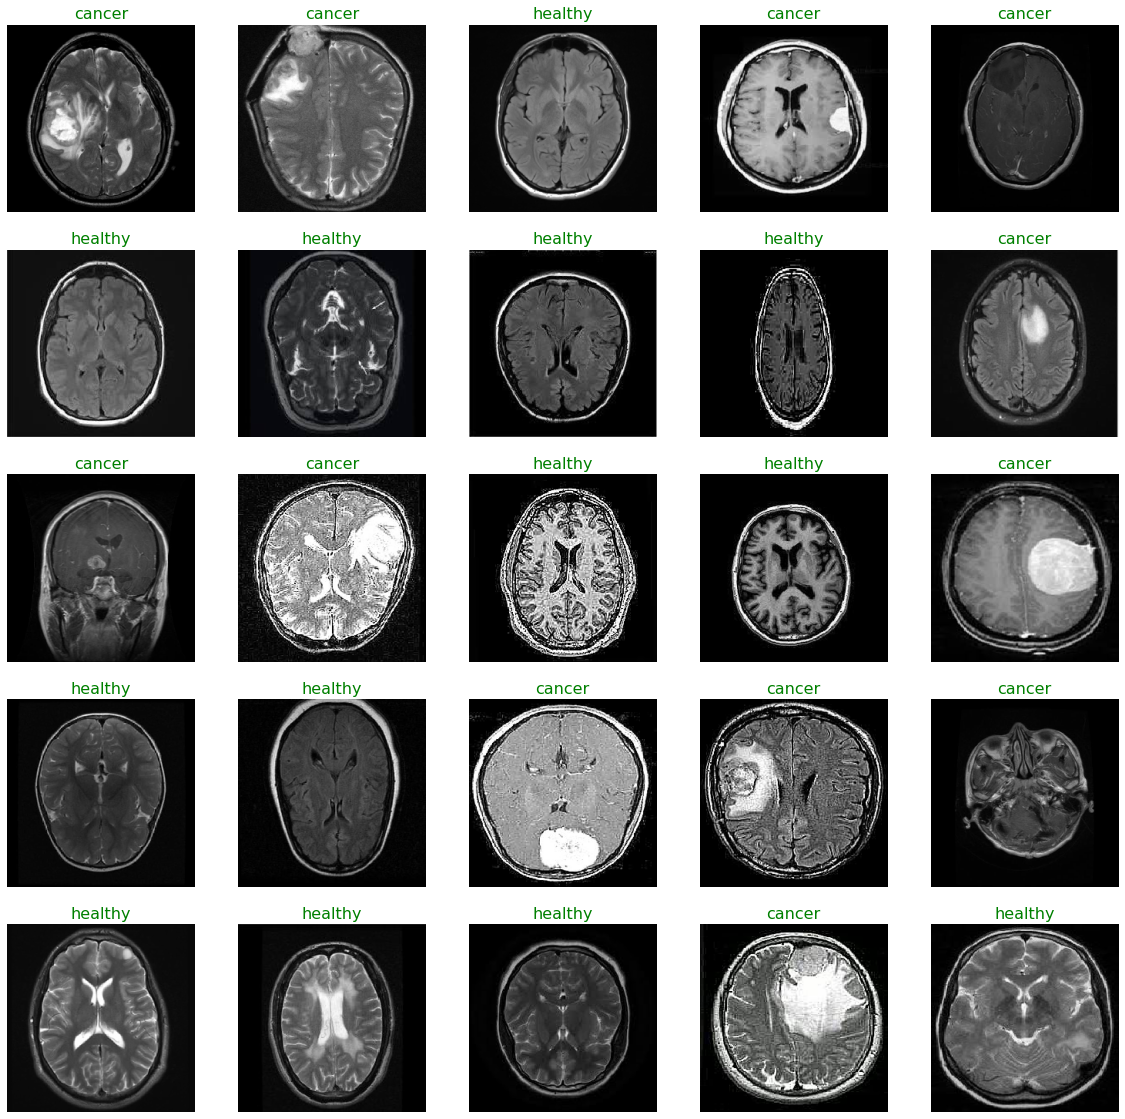

In [ ]:
show_brain_images(train)

In [ ]:
from tensorflow.keras.applications import VGG16
from keras import layers

vgg16_model = VGG16(weights = 'imagenet' ,include_top = False, input_shape = (224, 224, 3))
for layer in vgg16_model.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation = 'sigmoid'))
model.summary()

58900480/58889256 [==============================] - 49s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
____________________________________

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")
History = model.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 319s 2s/step - loss: 0.6928 - accuracy: 0.7948 - val_loss: 0.1991 - val_accuracy: 0.9272
Epoch 2/10
115/115 [==============================] - 173s 2s/step - loss: 0.2146 - accuracy: 0.9136 - val_loss: 0.1084 - val_accuracy: 0.9674
Epoch 3/10
115/115 [==============================] - 180s 2s/step - loss: 0.1258 - accuracy: 0.9579 - val_loss: 0.0787 - val_accuracy: 0.9761
Epoch 4/10
115/115 [==============================] - 189s 2s/step - loss: 0.0828 - accuracy: 0.9707 - val_loss: 0.0662 - val_accuracy: 0.9826
Epoch 5/10
115/115 [==============================] - 215s 2s/step - loss: 0.0802 - accuracy: 0.9685 - val_loss: 0.0691 - val_accuracy: 0.9772
Epoch 6/10
115/115 [==============================] - 226s 2s/step - loss: 0.0718 - accuracy: 0.9723 - val_loss: 0.0830 - val_accuracy: 0.9772
Epoch 7/10
115/115 [==============================] - 212s 2s/step - loss: 0.0784 - accuracy: 0.9671 - val_loss: 0.0522 - val_accuracy: 0.9859

In [ ]:
model.save('braintumormodel.h5')

Text(0.5, 1.0, 'Training and Validation Losses')

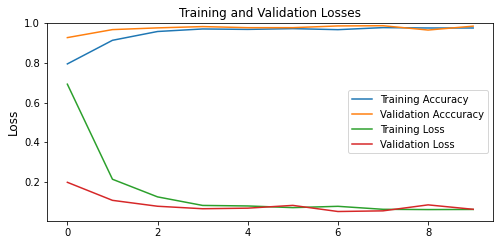

In [ ]:
acc = History.history["accuracy"] # report of model
val_acc = History.history["val_accuracy"] # history of validation data

loss = History.history["loss"]        # Training loss
val_loss = History.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns
#plotting respective accuracy
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

plt.subplot(2,1,1)
 
plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)

In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 71s 2s/step - loss: 0.0486 - accuracy: 0.9899


[0.04857860878109932, 0.9898550510406494]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import accuracy_score
y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      cancer       1.00      0.98      0.99       779
     healthy       0.98      1.00      0.99       601

    accuracy                           0.99      1380
   macro avg       0.99      0.99      0.99      1380
weighted avg       0.99      0.99      0.99      1380

Accuracy of the Model: 98.98550724637681 %


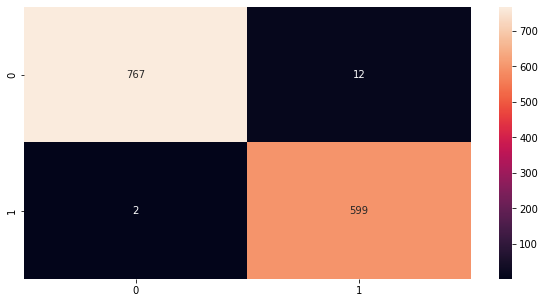

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

Cancer


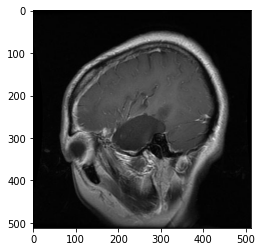

In [ ]:
import cv2
class_name = {0 : 'cancer', 1 : 'healthy'}
image = cv2.imread("/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg")
plt.imshow(image)
image = cv2.resize(image, (224, 224))
image = np.array(image)/255.0
image = np.reshape(image,(1,224,224,3))
predictions = model.predict(image)
predict_value = np.argmax(predictions, axis=1)
if (predict_value == 0):
  print ("Cancer")
else:
  print("Healthy")

Healthy


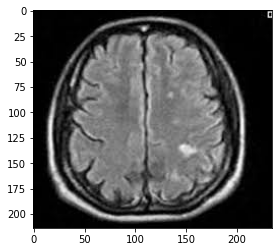

In [ ]:
image = cv2.imread("/content/data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1006).jpg")
plt.imshow(image)
image = cv2.resize(image, (224, 224))
image = np.array(image)/255.0
image = np.reshape(image,(1,224,224,3))
predictions = model.predict(image)
predict_value = np.argmax(predictions, axis=1)
if (predict_value == 0):
  print ("Cancer")
else:
  print("Healthy")